In [ ]:
import glob
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
baseline_results_dir = "../domain_shift_results"
tableshift_results_dir = "../ray_train_results"

In [ ]:
# experiments still in process; ignore any existing results for these.
in_process_expts = [
    'acsunemployment_year',
    'acspubcov_year',
    'anes_year',
    'brfss_blood_pressure_income',
    "_debug",
    'diabetes_admtype',  # not in progress - we just want to exclude from results (removed from benchmark)
    'heloc_burden',
    'nhanes_cholesterol_race',
    'physionet_set',
]

In [143]:
def extract_task_from_filepath(fp:str)->str:
    task = re.search(".*/domain_shift_results/(\w+)/.*", fp).group(1)
    return task

# a list of RGB values for categorical plotting
rgblist = list(sns.color_palette("colorblind", 16))

In [144]:
baseline_files = []

for expt in os.listdir(baseline_results_dir):
    if expt in in_process_expts:
        print(f"skipping in progress expt at {expt}")
        continue
    wc = os.path.join(baseline_results_dir, expt, "**", "**_full.csv")
    full_results = glob.glob(wc)
    if full_results:
        most_recent_result = sorted(full_results)[-1]
        print(f"got recent baseline result file for expt {expt}")
        baseline_files.append(most_recent_result)

skipping in progress expt at anes_year
got recent baseline result file for expt acsfoodstamps_region
got recent baseline result file for expt brfss_diabetes_race
got recent baseline result file for expt acsincome_region
got recent baseline result file for expt anes_region
got recent baseline result file for expt acspubcov_disability
got recent baseline result file for expt nhanes_lead_poverty
got recent baseline result file for expt mimic_extract_los_3_ins
got recent baseline result file for expt mooc_course
skipping in progress expt at _debug
skipping in progress expt at physionet_set
got recent baseline result file for expt diabetes_admsrc
skipping in progress expt at diabetes_admtype
skipping in progress expt at acspubcov_year
skipping in progress expt at nhanes_cholesterol_race
skipping in progress expt at acsunemployment_year
skipping in progress expt at heloc_burden
got recent baseline result file for expt mimic_extract_mort_hosp_ins
skipping in progress expt at brfss_blood_press

In [145]:
expt_files = []

for expt in os.listdir(tableshift_results_dir):
    if expt in in_process_expts:
        print(f"skipping in progress expt at {expt}")
        continue
    most_recent_iter = sorted(os.listdir(os.path.join(tableshift_results_dir, expt)))[-1]
    wc = os.path.join(tableshift_results_dir, expt, most_recent_iter, "*.csv")
    per_model_results = glob.glob(wc)
    if per_model_results:
        for fp in per_model_results:
            if "full.csv" in fp:
                continue
            print(f"got recent expt result file for expt {fp}")
            expt_files.append(fp)

got recent expt result file for expt ../ray_train_results/acsfoodstamps_region/20230116134402/tune_results_acsfoodstamps_region_20230116134402_acsfoodstampsdomain_split_varname_DIVISIONdomain_split_ood_value_06_dann.csv
got recent expt result file for expt ../ray_train_results/acsfoodstamps_region/20230116134402/tune_results_acsfoodstamps_region_20230116134402_acsfoodstampsdomain_split_varname_DIVISIONdomain_split_ood_value_06_ft_transformer.csv
got recent expt result file for expt ../ray_train_results/acsfoodstamps_region/20230116134402/tune_results_acsfoodstamps_region_20230116134402_acsfoodstampsdomain_split_varname_DIVISIONdomain_split_ood_value_06_irm.csv
got recent expt result file for expt ../ray_train_results/acsfoodstamps_region/20230116134402/tune_results_acsfoodstamps_region_20230116134402_acsfoodstampsdomain_split_varname_DIVISIONdomain_split_ood_value_06_resnet.csv
got recent expt result file for expt ../ray_train_results/acsfoodstamps_region/20230116134402/tune_results_ac

In [146]:
def extract_task_from_expt_filepath(f):
    return re.search(".*/ray_train_results/(\w+)/.*", f).group(1)

In [147]:
dfs = []
for f in baseline_files:
    df = pd.read_csv(f)
    task = extract_task_from_filepath(f)
    df["task"] = task
    dfs.append(df)
for f in expt_files:
    df = pd.read_csv(f)
    task = extract_task_from_expt_filepath(f)
    df["task"] = task
    dfs.append(df)
df = pd.concat(dfs)

In [148]:
print(df["estimator"].unique())
print(df["task"].unique())

['xgb' 'lightgbm' 'dann' 'ft_transformer' 'irm' 'resnet' 'mlp' 'deepcoral'
 'group_dro' 'dro' 'mmd' 'mixup' 'vrex']
['acsfoodstamps_region' 'brfss_diabetes_race' 'acsincome_region'
 'anes_region' 'acspubcov_disability' 'nhanes_lead_poverty'
 'mimic_extract_los_3_ins' 'mooc_course' 'diabetes_admsrc'
 'mimic_extract_mort_hosp_ins' 'mimic_extract_los_3']


In [149]:
def best_by_metric(df_in, metric='validation_accuracy'):
    df_out = df_in.groupby(['task', 'estimator'])\
               .apply(lambda group: group.nlargest(1, columns=metric))\
               .reset_index(drop=True)
    
    # check the outputs
    group_sizes = df_out.groupby(['task', 'estimator']).size()
    if not np.all(group_sizes.values == 1):
        print(group_sizes)
        raise ValueError("got unexpected results - more than one observation per group.")
    return df_out

In [150]:
best_acc = best_by_metric(df)

In [151]:
best_acc[['validation_accuracy', 'task', 'estimator', 'domain_split_ood_values']]

,validation_accuracy,task,estimator,domain_split_ood_values
0,0.812762,acsfoodstamps_region,dann,['6']
1,0.821791,acsfoodstamps_region,deepcoral,['6']
2,0.845905,acsfoodstamps_region,dro,['6']
3,0.844455,acsfoodstamps_region,ft_transformer,['6']
4,0.843921,acsfoodstamps_region,group_dro,['6']
5,0.817086,acsfoodstamps_region,irm,['6']
6,0.856806,acsfoodstamps_region,lightgbm,['05']
7,0.843909,acsfoodstamps_region,mlp,['6']
8,0.845155,acsfoodstamps_region,resnet,['6']
9,0.848165,acsfoodstamps_region,xgb,['07']


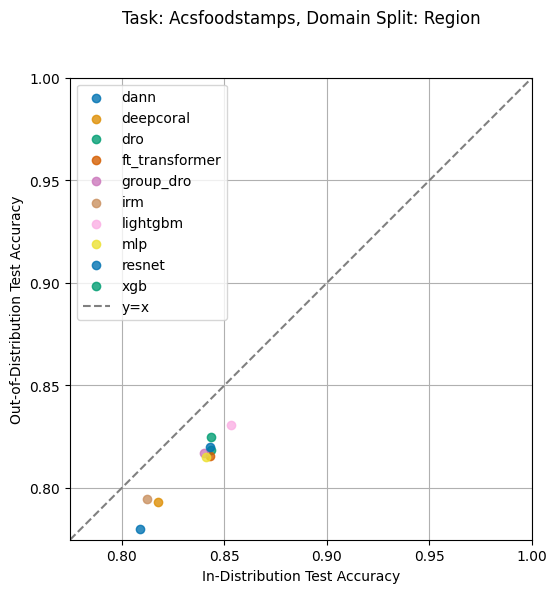

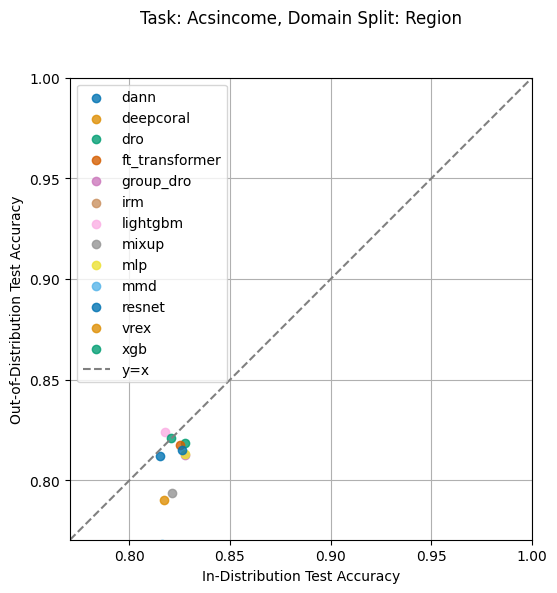

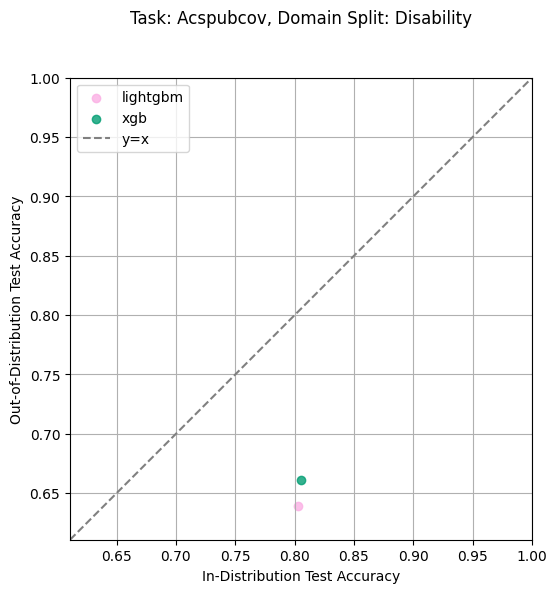

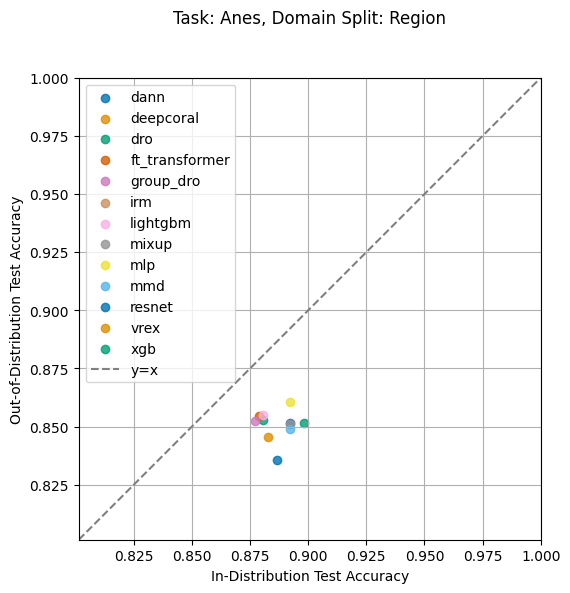

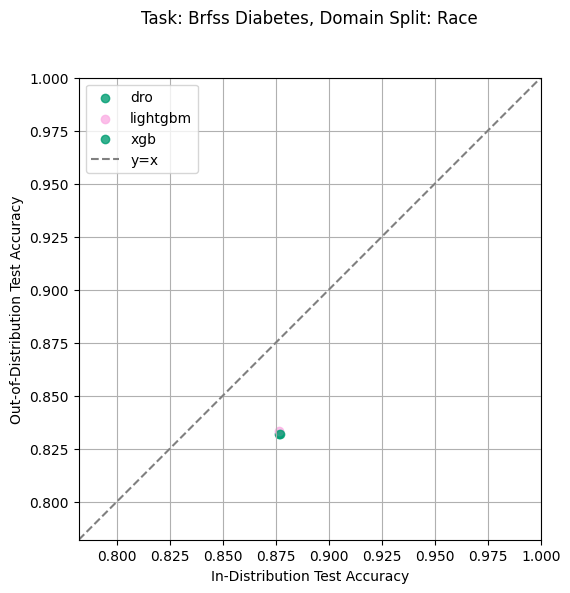

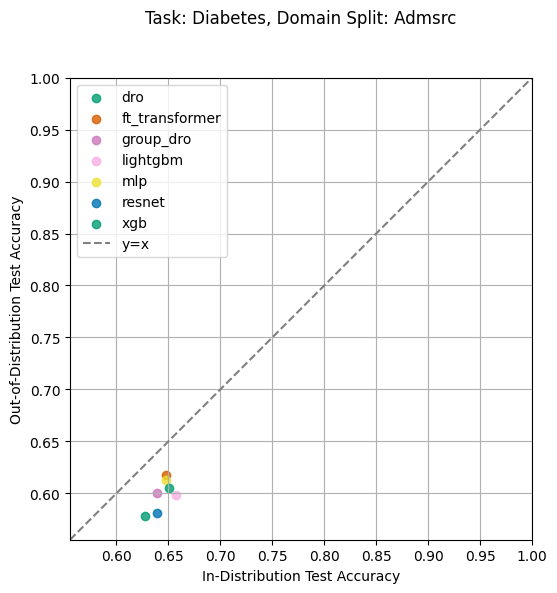

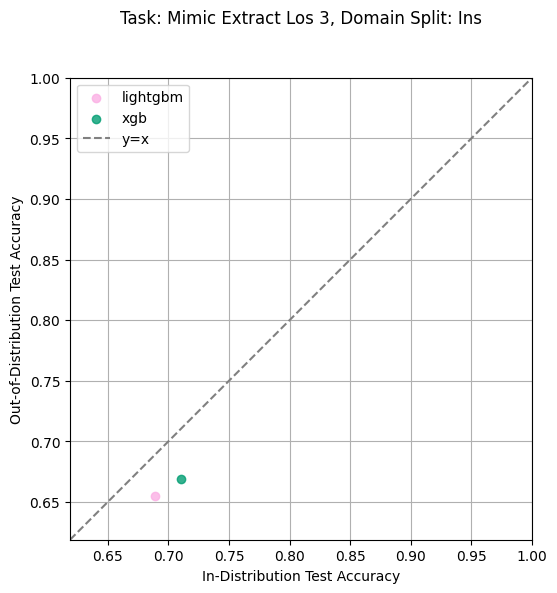

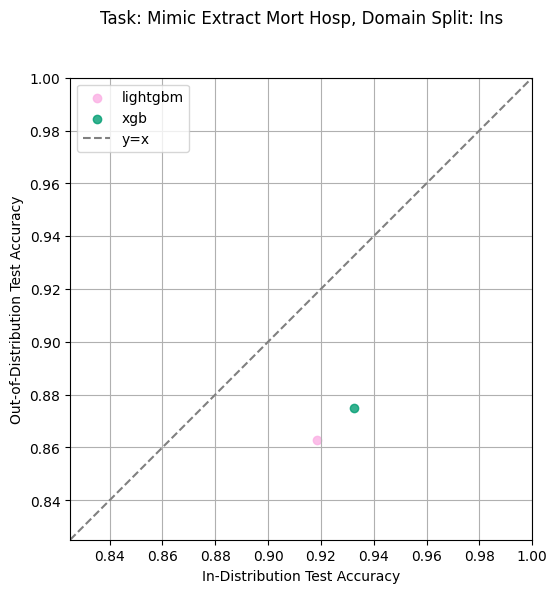

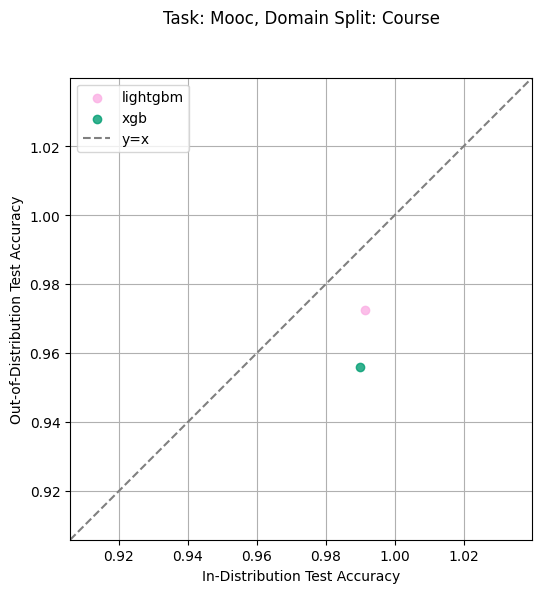

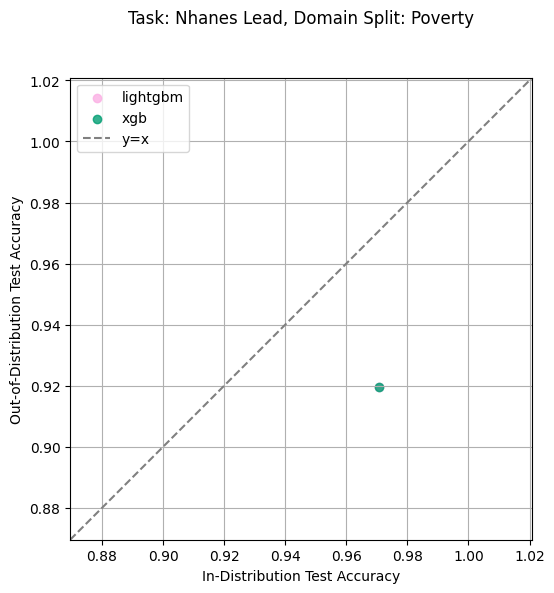

In [152]:
axpad = 0.05  # amount to pad x and y axes in either direction.
tasks = [x for x in sorted(best_acc.task.unique()) if task not in in_process_expts]
estimators = sorted(best_acc.estimator.unique())
for task in tasks:
    task_name, split_name = task.rsplit("_", 1)
    
    if not len(best_acc.query(f"task == '{task}'")) > 1:
        continue
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

    for i, estimator in enumerate(estimators):
        df_ = best_acc.query(f"estimator == '{estimator}' and task == '{task}'")
        if not len(df_):
#             print(f"empty dataframe for estimator {estimator} task {task}; skipping")
            continue
        assert len(df_) == 1, print(f"expected one element; got {len(df_)} for {estimator} task {task}")
        ax.scatter(df_['id_test_accuracy'].values, 
                    df_['ood_test_accuracy'].values,
                    # tmp['ood_id_test_accuracy_gap'],
                    label=estimator,
                   color=rgblist[i],
                    alpha=0.8)
    xymin = min(df_['id_test_accuracy'].values.min(),
                df_['ood_test_accuracy'].values.min()) - axpad

    xymax = max(df_['id_test_accuracy'].values.max(),
                df_['ood_test_accuracy'].values.max()) + axpad
    xymax = max(xymax, 1)
    ax.axline( (xymin,xymin), slope=1, linestyle="dashed", color="grey", label="y=x")        
    ax.set_xlabel("In-Distribution Test Accuracy")
    ax.set_ylabel("Out-of-Distribution Test Accuracy")
    ax.set(xlim=(xymin,xymax), ylim=(xymin,xymax))
    ax.set_aspect("equal")

    ax.legend()
    ax.grid()
    ax.set_title(f"Task: {task_name.replace('_', ' ').title()}, Domain Split: {split_name.title()}", y=1.1)

In [153]:
df_.set_index(
    keys=['task', 'estimator']
)[['validation_accuracy', 'id_test_accuracy', 'ood_test_accuracy']]\
.sort_index(level=[-2])

,,validation_accuracy,id_test_accuracy,ood_test_accuracy
task,estimator,,,
nhanes_lead_poverty,xgb,0.977642,0.970867,0.919588
